In [1]:
from datasets import load_dataset, load_from_disk
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd

from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Lambda, Dense
from tensorflow.keras import Model

## Get GloVe Embeddings

In [2]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [3]:
# !unzip glove.6B.zip

In [4]:
path_to_glove_file = os.path.join(
    '/kaggle/input/glovedata/glove.6B.100d.txt'
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


## Set a TextVectorization Layer to use all available words

In [5]:
vectorizer = TextVectorization(output_sequence_length=20)
vectorizer.set_vocabulary(list(embeddings_index.keys()))
print(f'Stored {len(vectorizer.get_vocabulary())} words in vocabulary.')
vectorizer.get_vocabulary()[:5]

Stored 400002 words in vocabulary.


['', '[UNK]', 'the', ',', '.']

In [6]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))    # Maps all tokens to their respective index

## Create an embeddings layer based on the embeddings

### First, create an embeddings matrix

In [7]:
num_tokens = len(voc) + 2
embedding_dim = 100  # We are using 100 dim embeddings
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 400000 words (2 misses)


### Now, create the layer

In [8]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    input_length=20
)

## Data Processing

In [9]:
# def vectorizerFn(example):
#     example['sentence1'] = vectorizer(example['sentence1'])
#     example['sentence2'] = vectorizer(example['sentence2'])
#     return example

# dataset = load_dataset("paws", "labeled_final")

# dataset['train'] = dataset['train'].map(vectorizerFn)
# dataset['test'] = dataset['test'].map(vectorizerFn)
# dataset['validation'] = dataset['validation'].map(vectorizerFn)

# dataset.save_to_disk("all_processes_data")

In [10]:
dataset = load_from_disk("/kaggle/input/all-processed-data-siamese-nw-for-sentence-sim/kaggle/working/all_processes_data")

In [11]:
data = dict()
data['train'] = dict()
data['validation'] = dict()
data['test'] = dict()

for split_name in ['train', 'validation', 'test']:
    data[split_name]['sentence1'] = np.array(dataset[split_name]['sentence1'])
    data[split_name]['sentence2'] = np.array(dataset[split_name]['sentence2'])
    data[split_name]['label'] = np.array(dataset[split_name]['label']).reshape((-1, 1))

In [12]:
data['train']['sentence1'].shape

(49401, 20)

## Create The Model

In [13]:
lstm_layer = LSTM(4, return_sequences=False)
l1_layer = Lambda(lambda x: tf.keras.backend.abs(x[0] - x[1]))

input1 = tf.keras.Input(shape=(20,), name='sentence1')
input2 = tf.keras.Input(shape=(20,), name='sentence2')

e1 = embedding_layer(input1)
e2 = embedding_layer(input2)

x1 = lstm_layer(e1)
x2 = lstm_layer(e2)

l1_dist = l1_layer([x1, x2])

pred = Dense(1, activation='sigmoid', name='equalProb')(l1_dist)

model = Model(inputs=[input1, input2], outputs=[pred])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentence1 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 sentence2 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 100)      40000400    ['sentence1[0][0]',              
                                                                  'sentence2[0][0]']              
                                                                                                  
 lstm (LSTM)                    (None, 4)            1680        ['embedding[0][0]',          

In [15]:
model.compile(loss='BinaryCrossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])

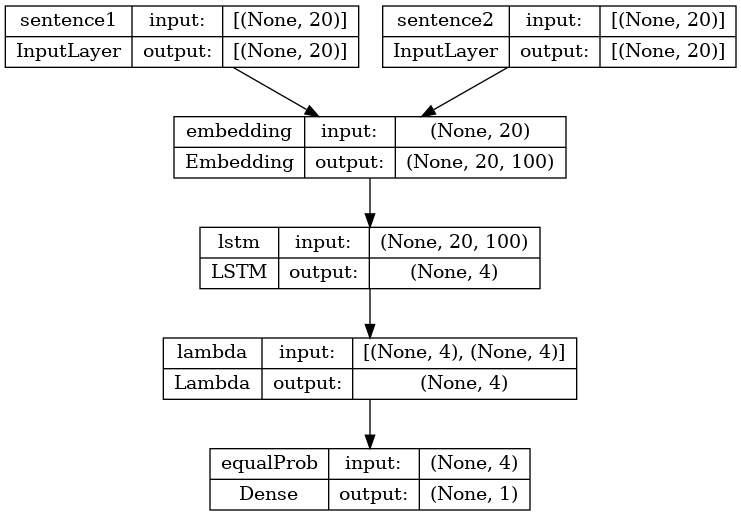

In [16]:
keras.utils.plot_model(model, "siamese_model.png", show_shapes=True)

In [17]:
# Sample Inputs

# s1_data = np.random.randint(20, size=(2, 20))
# s2_data = np.random.randint(20, size=(2, 20))
# label_data = np.random.randint(2, size=(2, 1))
# model.predict({"sentence1": s1_data, "sentence2": s2_data})
# model.fit({"sentence1": s1_data, "sentence2": s2_data}, {'equalProb': label_data})

## Train The Model

In [18]:
model.fit(
    x={"sentence1": data['train']["sentence1"], "sentence2": data['train']["sentence2"]}, 
    y={'equalProb': data['train']['label']},
    epochs=100,
    validation_data=({"sentence1": data['validation']["sentence1"], "sentence2": data['validation']["sentence2"]}, {'equalProb': data['validation']['label']})
)

Epoch 1/100
1544/1544 [==============================] - 22s 8ms/step - loss: 0.6758 - binary_accuracy: 0.5586 - val_loss: 0.6606 - val_binary_accuracy: 0.5765
Epoch 2/100
1544/1544 [==============================] - 11s 7ms/step - loss: 0.6445 - binary_accuracy: 0.6195 - val_loss: 0.6344 - val_binary_accuracy: 0.6351
Epoch 3/100
1544/1544 [==============================] - 11s 7ms/step - loss: 0.6220 - binary_accuracy: 0.6510 - val_loss: 0.6235 - val_binary_accuracy: 0.6501
Epoch 4/100
1544/1544 [==============================] - 11s 7ms/step - loss: 0.6074 - binary_accuracy: 0.6658 - val_loss: 0.6215 - val_binary_accuracy: 0.6543
Epoch 5/100
1544/1544 [==============================] - 11s 7ms/step - loss: 0.5980 - binary_accuracy: 0.6731 - val_loss: 0.6196 - val_binary_accuracy: 0.6530
Epoch 6/100
1544/1544 [==============================] - 11s 7ms/step - loss: 0.5913 - binary_accuracy: 0.6807 - val_loss: 0.6186 - val_binary_accuracy: 0.6511
Epoch 7/100
1544/1544 [=================

## Save Model

In [19]:
# model.save('model')

## Test Set accuracy

In [20]:
def getTestSetAccuracy():
    test_preds = model.predict({"sentence1": data['test']["sentence1"], "sentence2": data['test']["sentence2"]}, verbose=0)
    m = tf.keras.metrics.BinaryAccuracy()
    m.update_state(data['test']["label"], test_preds)
    return m.result().numpy()

getTestSetAccuracy()

0.6555

## Make Predictions

In [21]:
def getSimilarityProbability(s1: str, s2: str):
    s1 = s1.lower()
    s2 = s2.lower()
    v1 = vectorizer(s1)
    v2 = vectorizer(s2)
    return model.predict({"sentence1": np.array(v1).reshape((1, -1)), "sentence2": np.array(v2).reshape((1, -1))}, verbose=0)[0][0]

In [22]:
getSimilarityProbability('you are sleeping', 'are you sleeping?')

0.8029901